In [134]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm

from statsmodels.sandbox.regression.gmm import IV2SLS 
# There is a package named IV2SLS in Python. Do not use this package! The exogenous explanatory variables must
# be entered as instruments. So it gives wrong answers
from statsmodels.sandbox.regression.gmm import GMM
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

**PART 1 (20%)**

In [135]:
input_table = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Predictive Modelling | MBAN 5110 U /Midterm/midterm_partone.csv')

In [136]:
input_table.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [137]:
y_vals  = np.array(input_table["Stock Change"])
x_vals  = np.array(input_table[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] 
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] 
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] 

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1])
res = gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, k_moms=6, k_params=4).fit(beta0)

res.summary()

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 gmm Results                                  
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                            gmm   Prob (Hansen J):                 0.729
Method:                           GMM                                         
Date:                Fri, 10 Nov 2023                                         
Time:                        10:51:47                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0200      0.021     -0.964      0.335      -0.061       0.021
p 1            0.0011      0.001      1.843      0.065   -6.89e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
==============================================================================
"""

## 1. Update the GMM model that we discussed in class by incorporating the 𝛿 term to the instrumental-variable moment expressions.##

In [138]:
y_vals  = np.array(input_table["Stock Change"])
x_vals  = np.array(input_table[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3, delta = params #Included delta term here
        endog = self.endog
        exog = self.exog
        inst = self.instrument   
#Added the delta term to the error calculations.
        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1) * inst[:,0]
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1) * inst[:,1]
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2] - delta * 1) * inst[:,2]

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

beta0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
res = gmm(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5).fit(beta0)

res.summary()


Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 gmm Results                                  
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                            gmm   Prob (Hansen J):                 0.427
Method:                           GMM                                         
Date:                Fri, 10 Nov 2023                                         
Time:                        10:51:47                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0100    1.5e+06  -6.68e-09      1.000   -2.94e+06    2.94e+06
p 1            0.0011      0.001      1.843      0.065    -6.9e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
p 4           -0.0100    1.5e+06  -6.68e-09      1.000   -2.94e+06    2.94e+06
==============================================================================
"""

## Standard Error ##
In the initial model, the standard errors are all quite small. With the includion of the delta variable, the standard error of p0 becomes very large, as well as the standard error of p4. This suggests that estimating the value of this coeffecients becomes very unstable/inconsistent. 

## Statistical significance (Z & P Scores) ##
Although p1,p2 & p3 values did not change, p0 went from having some significance (p score of 0.335, z score -0.964), to having no significance (z-score of -6.68e-09, p-score of 1.000). The delta value p4 has the exact same z and p score as p0, suggesting no statistical significance on the dependent variable.


In [139]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/Predictive Modelling | MBAN 5110 U /Midterm/midterm_parttwo.csv')

In [140]:
df_unchanged = df.copy()

In [141]:
print(df['Requested Credit Amount'].unique())
print(df['Number of Dependents'].unique())
print(df['Monthly Income'].unique())
print(df['Monthly Expense'].unique())
print(df['Marital Status'].unique())
print(df['Credit Rating'].unique())

['Low' 'Medium' 'High']
['No dependent' 'Less than 2' 'More than 2']
['Very low' 'Low' 'Moderate' 'High' 'Very High']
['Very low' 'Low' 'Moderate' 'High' 'Very high']
['Married' 'Single' 'Not specified']
['Positive' 'Negative']


In [142]:
df['Requested Credit Amount'] = df['Requested Credit Amount'].map({'Low': 1, 'Medium': 2, 'High': 3})
df['Number of Dependents'] = df['Number of Dependents'].map({'No dependent': 1, 'Less than 2': 2, 'More than 2': 3})
df['Monthly Income'] = df['Monthly Income'].map({'Very low':1, 'Low':2, 'Moderate': 3, 'High': 4, 'Very High': 5})
df['Monthly Expense'] = df['Monthly Expense'].map({'Very low':1, 'Low':2, 'Moderate': 3, 'High': 4, 'Very high': 5})
df['Marital Status'] = df['Marital Status'].map({'Married':1, 'Single':2, 'Not specified': 3})
df['Credit Rating'] = df['Credit Rating'].map({'Positive':1, 'Negative':0})


In [143]:
print(df['Requested Credit Amount'].unique())
print(df['Number of Dependents'].unique())
print(df['Monthly Income'].unique())
print(df['Monthly Expense'].unique())
print(df['Marital Status'].unique())
print(df['Credit Rating'].unique())

[1 2 3]
[1 2 3]
[1 2 3 4 5]
[1 2 3 4 5]
[1 2 3]
[1 0]


In [144]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,1,1,1,1,1,1
1,2,1,1,1,1,2,1
2,1,1,1,1,1,2,1
3,3,1,1,1,1,1,1
4,3,1,1,1,1,2,0


In [145]:
df['Requested Credit Amount'].unique()

array([1, 2, 3])

In [146]:
train, test = train_test_split(df, test_size=0.5, random_state=42)

X_train = train.drop('Credit Rating', axis=1)
y_train = train['Credit Rating']
X_test = test.drop('Credit Rating', axis=1)
y_test = test['Credit Rating']

In [147]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [148]:
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nRecall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


Confusion Matrix:
 [[   0  577]
 [   0 3464]]

Recall: 1.0
Precision: 0.8572135609997525
F1 Score: 0.9231179213857428


In [149]:
model.coef_

array([[ 0.07044547, -0.11513449,  0.16900548, -0.09915283,  0.0781597 ,
         0.1366732 ]])

In [150]:
y_train.unique()

array([1, 0])

In [151]:
y_scores = model.predict_proba(X_test)[:, 1]  # get the probabilities of the positive class
threshold_15 = np.percentile(y_scores, 85)  # 85th percentile because we want the top 15%

# Applying the new threshold
y_pred_15 = (y_scores >= threshold_15).astype(int)

# Updated Model Evaluation
conf_matrix_15 = confusion_matrix(y_test, y_pred_15)
recall_15 = recall_score(y_test, y_pred_15)
precision_15 = precision_score(y_test, y_pred_15)
f1_15 = f1_score(y_test, y_pred_15)

print("Updated Confusion Matrix:\n", conf_matrix_15)
print("\nUpdated Recall:", recall_15)
print("Updated Precision:", precision_15)
print("Updated F1 Score:", f1_15)


Updated Confusion Matrix:
 [[ 499   78]
 [2922  542]]

Updated Recall: 0.1564665127020785
Updated Precision: 0.8741935483870967
Updated F1 Score: 0.2654260528893242


In [152]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_test)

array([0, 1])

In [153]:
def plot(y_train, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted {label}' for label in labels]
    indices = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_train, y_pred),
                         columns=column, index=indices)
    return table
    

In [154]:
plot(y_test, y_pred)

,Predicted 0,Predicted 1
Actual 0,0,577
Actual 1,0,3464


In [156]:
def plot2(y_train, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted {label}' for label in labels]
    indices = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_train, y_pred),
                         columns=column, index=indices)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<Axes: >

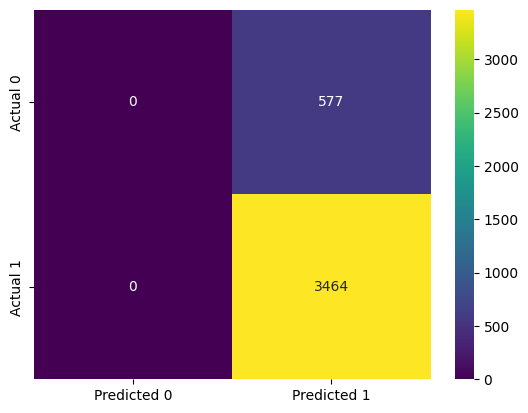

In [157]:
plot2(y_test, y_pred)